In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, MultiLabelBinarizer
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix, precision_score, recall_score, roc_auc_score, r2_score, mean_absolute_error, max_error, mean_squared_error
import xgboost as xgb
import shap
from itertools import chain
from ast import literal_eval

c:\Users\CYBORG\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
data = pd.read_csv('data.csv')

In [6]:
data["abilities"] = data["abilities"].apply(literal_eval)

mlb = MultiLabelBinarizer()
abilities = pd.DataFrame(
    mlb.fit_transform(data["abilities"]),
    columns=mlb.classes_
)
data = pd.concat([data.drop("abilities", axis=1), abilities], axis=1)

data = data[data['type2'].notna()]

data['height_m'] = data.height_m.fillna(data.height_m.median())
data['percentage_male'] = data.percentage_male.fillna(data.percentage_male.median())
data['weight_kg'] = data.weight_kg.fillna(data.weight_kg.median())

data = data[data['capture_rate'] != "30 (Meteorite)255 (Core)"]
data['capture_rate'] = pd.to_numeric(data['capture_rate'])

data['type1'] = data['type1'].replace(['psychic', 'flying'], 'group1')
data['type1'] = data['type1'].replace(['fighting', 'poison'], 'group2')
data['type1'] = data['type1'].replace(['normal'], 'group3')
data['type1'] = data['type1'].replace(['dragon', 'steel'], 'group4')
data['type1'] = data['type1'].replace(['bug', 'ghost'], 'group5')
data['type1'] = data['type1'].replace(['fairy', 'grass', 'water'], 'group6')
data['type1'] = data['type1'].replace(['ice', 'rock'], 'group7')
data['type1'] = data['type1'].replace(['dark', 'fire'], 'group8')
data['type1'] = data['type1'].replace(['electric'], 'group9')
data['type1'] = data['type1'].replace(['ground'], 'group10')
data = pd.get_dummies(data, columns=['type1'])

data['type2'] = data['type2'].replace(['bug', 'dark', 'normal', 'rock'], 'group1')
data['type2'] = data['type2'].replace(['electric', 'flying'], 'group2')
data['type2'] = data['type2'].replace(['ground', 'poison'], 'group3')
data['type2'] = data['type2'].replace(['fairy', 'steel'], 'group4')
data['type2'] = data['type2'].replace(['ghost', 'fire', 'psychic'], 'group5')
data['type2'] = data['type2'].replace(['dragon', 'fighting'], 'group6')
data['type2'] = data['type2'].replace(['ice', 'water', 'grass'], 'group7')
data = pd.get_dummies(data, columns=['type2'])

data['generation'] = data['generation'].replace([3, 5, 6], '3, 5, 6')
data = pd.get_dummies(data, columns=['generation'])

#scaler = MinMaxScaler()
scaler = StandardScaler()
data['against_bug'] = scaler.fit_transform(data[['against_bug']])
data['against_dark'] = scaler.fit_transform(data[['against_dark']])
data['against_dragon'] = scaler.fit_transform(data[['against_dragon']])
data['against_electric'] = scaler.fit_transform(data[['against_electric']])
data['against_fairy'] = scaler.fit_transform(data[['against_fairy']])
data['against_fight'] = scaler.fit_transform(data[['against_fight']])
data['against_fire'] = scaler.fit_transform(data[['against_fire']])
data['against_flying'] = scaler.fit_transform(data[['against_flying']])
data['against_ghost'] = scaler.fit_transform(data[['against_ghost']])
data['against_grass'] = scaler.fit_transform(data[['against_grass']])
data['against_ground'] = scaler.fit_transform(data[['against_ground']])
data['against_ice'] = scaler.fit_transform(data[['against_ice']])
data['against_normal'] = scaler.fit_transform(data[['against_normal']])
data['against_poison'] = scaler.fit_transform(data[['against_poison']])
data['against_psychic'] = scaler.fit_transform(data[['against_psychic']])
data['against_rock'] = scaler.fit_transform(data[['against_rock']])
data['against_steel'] = scaler.fit_transform(data[['against_steel']])
data['against_water'] = scaler.fit_transform(data[['against_water']])
data['attack'] = scaler.fit_transform(data[['attack']])
data['base_egg_steps'] = scaler.fit_transform(data[['base_egg_steps']])
data['base_happiness'] = scaler.fit_transform(data[['base_happiness']])
data['base_total'] = scaler.fit_transform(data[['base_total']])
data['capture_rate'] = scaler.fit_transform(data[['capture_rate']])
data['defense'] = scaler.fit_transform(data[['defense']])
data['experience_growth'] = scaler.fit_transform(data[['experience_growth']])
data['height_m'] = scaler.fit_transform(data[['height_m']])
data['hp'] = scaler.fit_transform(data[['hp']])
data['percentage_male'] = scaler.fit_transform(data[['percentage_male']])
data['pokedex_number'] = scaler.fit_transform(data[['pokedex_number']])
data['sp_attack'] = scaler.fit_transform(data[['sp_attack']])
data['sp_defense'] = scaler.fit_transform(data[['sp_defense']])
data['speed'] = scaler.fit_transform(data[['speed']])
data['weight_kg'] = scaler.fit_transform(data[['weight_kg']])

In [65]:
print(data.columns)

Index(['against_bug', 'against_dark', 'against_dragon', 'against_electric',
       'against_fairy', 'against_fight', 'against_fire', 'against_flying',
       'against_ghost', 'against_grass',
       ...
       'type2_group3', 'type2_group4', 'type2_group5', 'type2_group6',
       'type2_group7', 'generation_1', 'generation_2', 'generation_4',
       'generation_7', 'generation_3, 5, 6'],
      dtype='object', length=286)


In [66]:
print(data.columns.tolist())

['against_bug', 'against_dark', 'against_dragon', 'against_electric', 'against_fairy', 'against_fight', 'against_fire', 'against_flying', 'against_ghost', 'against_grass', 'against_ground', 'against_ice', 'against_normal', 'against_poison', 'against_psychic', 'against_rock', 'against_steel', 'against_water', 'attack', 'base_egg_steps', 'base_happiness', 'base_total', 'capture_rate', 'classfication', 'defense', 'experience_growth', 'height_m', 'hp', 'japanese_name', 'name', 'percentage_male', 'pokedex_number', 'sp_attack', 'sp_defense', 'speed', 'weight_kg', 'is_legendary', 'Adaptability', 'Aftermath', 'Air Lock', 'Analytic', 'Anger Point', 'Anticipation', 'Arena Trap', 'Aroma Veil', 'Aura Break', 'Bad Dreams', 'Battery', 'Battle Armor', 'Battle Bond', 'Beast Boost', 'Berserk', 'Big Pecks', 'Blaze', 'Bulletproof', 'Cheek Pouch', 'Chlorophyll', 'Clear Body', 'Cloud Nine', 'Color Change', 'Comatose', 'Competitive', 'Compoundeyes', 'Contrary', 'Corrosion', 'Cursed Body', 'Cute Charm', 'Dam

In [7]:
columns = [
    'against_bug', 'against_dark', 'against_dragon', 'against_electric', 'against_fairy', 'against_fight', 'against_fire', 'against_flying', 'against_ghost', 'against_grass', 'against_ground', 'against_ice', 'against_normal', 'against_poison', 'against_psychic', 'against_rock', 'against_steel', 'against_water',
    'attack', 'base_egg_steps', 'base_happiness', 'base_total', 'capture_rate',
       'defense', 'experience_growth', 'height_m', 'hp',
       'percentage_male', 'pokedex_number', 'sp_attack', 'sp_defense', 'speed', 'weight_kg',
       'type1_group1', 'type1_group10', 'type1_group2', 'type1_group3',
       'type1_group4', 'type1_group5', 'type1_group6', 'type1_group7',
       'type1_group8', 'type1_group9', 'type2_group1', 'type2_group2',
       'type2_group3', 'type2_group4', 'type2_group5', 'type2_group6',
       'type2_group7', 'generation_1', 'generation_2', 'generation_4',
       'generation_7', 'generation_3, 5, 6', 'Adaptability', 'Aftermath', 'Air Lock', 'Analytic', 'Anger Point', 'Anticipation', 'Arena Trap', 'Aroma Veil', 'Aura Break', 'Bad Dreams', 'Battery', 'Battle Armor', 'Battle Bond', 'Beast Boost', 'Berserk', 'Big Pecks', 'Blaze', 'Bulletproof', 'Cheek Pouch', 'Chlorophyll', 'Clear Body', 'Cloud Nine', 'Color Change', 'Comatose', 'Competitive', 'Compoundeyes', 'Contrary', 'Corrosion', 'Cursed Body', 'Cute Charm', 'Damp', 'Dancer', 'Dark Aura', 'Dazzling', 'Defeatist', 'Defiant', 'Disguise', 'Download', 'Drizzle', 'Drought', 'Dry Skin', 'Early Bird', 'Effect Spore', 'Electric Surge', 'Emergency Exit', 'Fairy Aura', 'Filter', 'Flame Body', 'Flare Boost', 'Flash Fire', 'Flower Gift', 'Flower Veil', 'Fluffy', 'Forecast', 'Forewarn', 'Friend Guard', 'Frisk', 'Full Metal Body', 'Fur Coat', 'Gale Wings', 'Galvanize', 'Gluttony', 'Gooey', 'Grass Pelt', 'Grassy Surge', 'Guts', 'Harvest', 'Healer', 'Heatproof', 'Heavy Metal', 'Honey Gather', 'Huge Power', 'Hustle', 'Hydration', 'Hyper Cutter', 'Ice Body', 'Illuminate', 'Illusion', 'Immunity', 'Imposter', 'Infiltrator', 'Innards Out', 'Inner Focus', 'Insomnia', 'Intimidate', 'Iron Barbs', 'Iron Fist', 'Justified', 'Keen Eye', 'Klutz', 'Leaf Guard', 'Levitate', 'Light Metal', 'Lightningrod', 'Limber', 'Liquid Ooze', 'Liquid Voice', 'Long Reach', 'Magic Bounce', 'Magic Guard', 'Magician', 'Magma Armor', 'Magnet Pull', 'Marvel Scale', 'Mega Launcher', 'Merciless', 'Minus', 'Misty Surge', 'Mold Breaker', 'Moody', 'Motor Drive', 'Moxie', 'Multiscale', 'Multitype', 'Mummy', 'Natural Cure', 'No Guard', 'Normalize', 'Oblivious', 'Overcoat', 'Overgrow', 'Own Tempo', 'Pickpocket', 'Pickup', 'Pixilate', 'Plus', 'Poison Heal', 'Poison Point', 'Poison Touch', 'Power Construct', 'Power of Alchemy', 'Prankster', 'Pressure', 'Prism Armor', 'Protean', 'Psychic Surge', 'Pure Power', 'Queenly Majesty', 'Quick Feet', 'RKS System', 'Rain Dish', 'Rattled', 'Receiver', 'Reckless', 'Refrigerate', 'Regenerator', 'Rivalry', 'Rock Head', 'Rough Skin', 'Run Away', 'Sand Force', 'Sand Rush', 'Sand Stream', 'Sand Veil', 'Sap Sipper', 'Schooling', 'Scrappy', 'Serene Grace', 'Shadow Shield', 'Shadow Tag', 'Shed Skin', 'Sheer Force', 'Shell Armor', 'Shield Dust', 'Shields Down', 'Simple', 'Skill Link', 'Slow Start', 'Slush Rush', 'Sniper', 'Snow Cloak', 'Snow Warning', 'Solar Power', 'Solid Rock', 'Soul-Heart', 'Soundproof', 'Speed Boost', 'Stakeout', 'Stall', 'Stamina', 'Stance Change', 'Static', 'Steadfast', 'Steelworker', 'Stench', 'Sticky Hold', 'Storm Drain', 'Strong Jaw', 'Sturdy', 'Suction Cups', 'Super Luck', 'Surge Surfer', 'Swarm', 'Sweet Veil', 'Swift Swim', 'Symbiosis', 'Synchronize', 'Tangled Feet', 'Tangling Hair', 'Technician', 'Telepathy', 'Teravolt', 'Thick Fat', 'Tinted Lens', 'Torrent', 'Tough Claws', 'Toxic Boost', 'Trace', 'Triage', 'Truant', 'Turboblaze', 'Unaware', 'Unburden', 'Unnerve', 'Victory Star', 'Vital Spirit', 'Volt Absorb', 'Water Absorb', 'Water Bubble', 'Water Compaction', 'Water Veil', 'Weak Armor', 'White Smoke', 'Wimp Out', 'Wonder Guard', 'Wonder Skin ', 'Zen Mode'
]

x = data[columns]
y = data['is_legendary']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [10]:
model = xgb.XGBClassifier(
    max_death=5,
    learning_rate=0.02,
    subsample=0.8,
    colsample_bytree=0.8,
    n_estimators=300,
    random_state=42,
    base_score=y_train.mean(),
    n_jobs=-1
)

model.fit(x_train, y_train,
    eval_set=[(x_test, y_test)],
    verbose=False)

y_pred = model.predict(x_test)

c:\Users\CYBORG\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:01:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "max_death" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


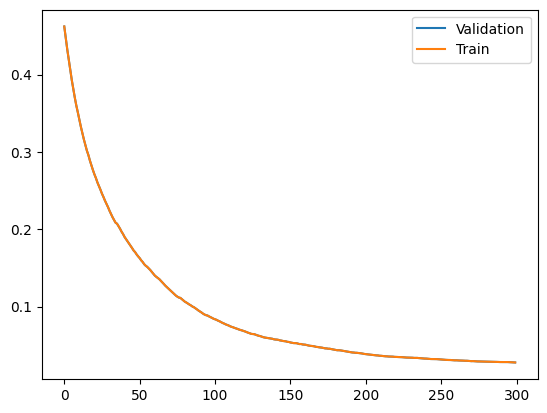

In [11]:
results = model.evals_result()
plt.plot(results['validation_0']['logloss'], label='Validation')
plt.plot(results['validation_0']['logloss'], label='Train')
plt.legend()
plt.show()

In [12]:
print("\nТестовая accuracy:", accuracy_score(y_test, y_pred))
print("Test F1-score:", f1_score(y_test, y_pred))
# print("\nОтчёт классификации:")
print(classification_report(y_test, y_pred))
print('precision:', precision_score(y_test, y_pred))
print('recall:', recall_score(y_test, y_pred))
print('roc_auc:', roc_auc_score(y_test, y_pred))


Тестовая accuracy: 0.9880952380952381
Test F1-score: 0.9629629629629629
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        70
           1       1.00      0.93      0.96        14

    accuracy                           0.99        84
   macro avg       0.99      0.96      0.98        84
weighted avg       0.99      0.99      0.99        84

precision: 1.0
recall: 0.9285714285714286
roc_auc: 0.9642857142857143


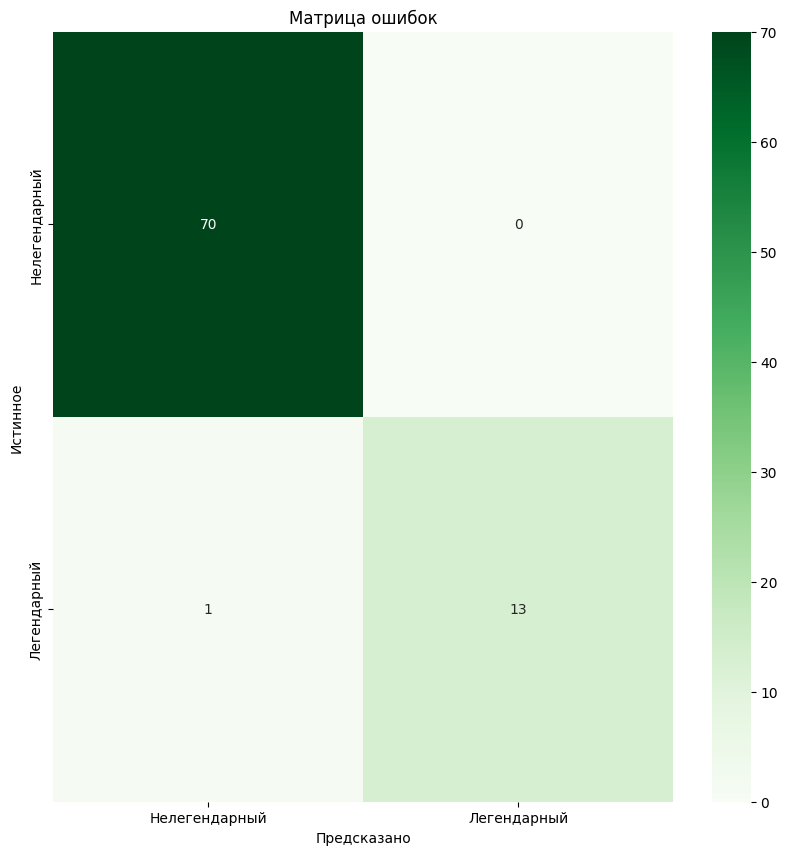

In [13]:
matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Greens', xticklabels=['Нелегендарный', 'Легендарный'], yticklabels=['Нелегендарный', 'Легендарный'])
plt.xlabel('Предсказано')
plt.ylabel('Истинное')
plt.title('Матрица ошибок')
plt.show()

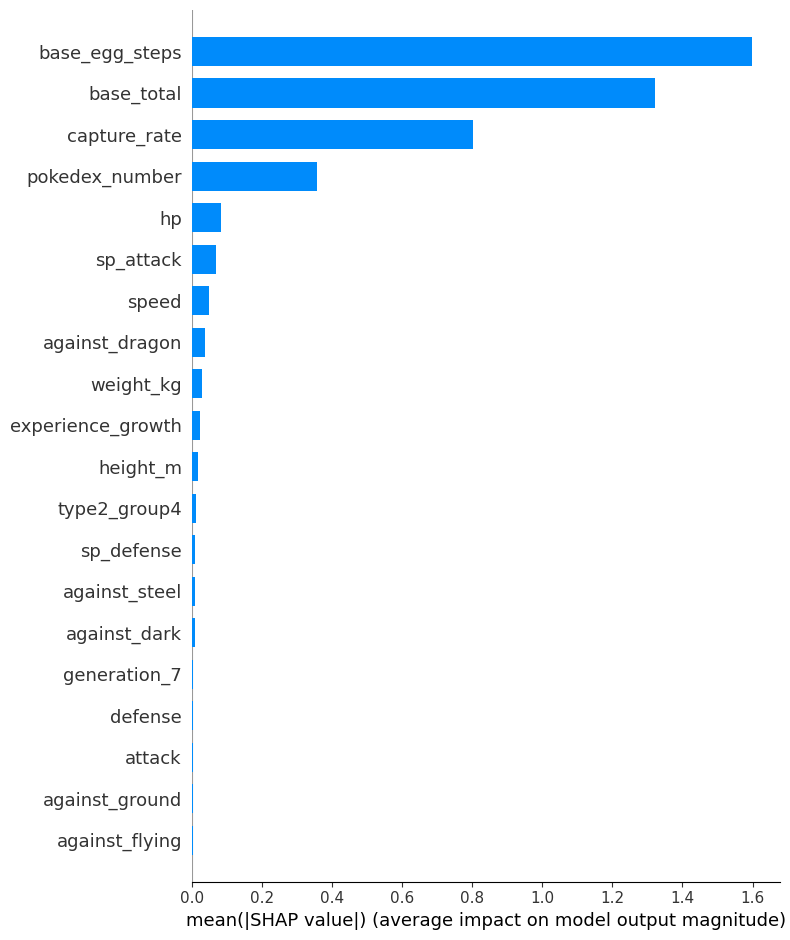

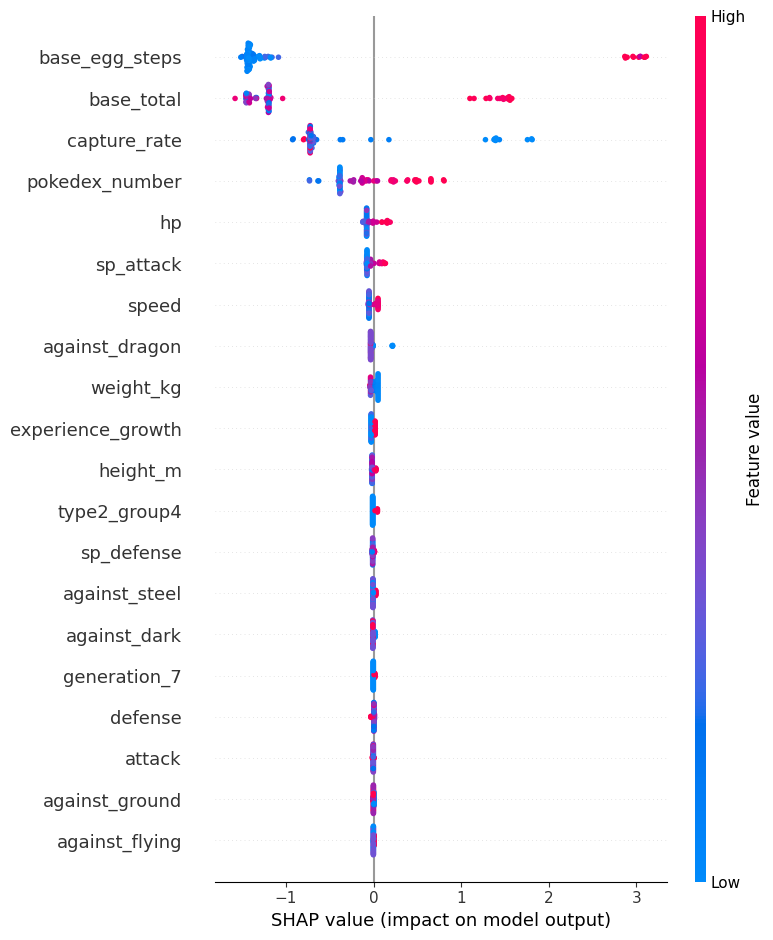

In [14]:
explainer = shap.Explainer(model)
shap_values = explainer(x_test)

shap.summary_plot(shap_values, x_test, plot_type="bar")

shap.summary_plot(shap_values, x_test)

In [15]:
from skops.io import dump
import json

# 3. Сохраняем метрики
metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "f1_score": f1_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),
}
pd.DataFrame([metrics]).to_csv('metrics.csv', index=False)

# 4. Сохраняем тестовые данные для визуализации
test_data = {
    "x_test": x_test.to_dict(orient='list'),
    "y_test": y_test.tolist(),
    "y_pred": y_pred.tolist(),
}

with open('test_data.json', 'w', encoding='utf-8') as f:
    json.dump(test_data, f, indent=4)

In [16]:
import joblib

# Сохраняем модель в бинарный файл (лучше использовать .pkl или .joblib)
joblib.dump(model, 'pokemons.pkl', protocol=4)  # protocol=4 для совместимости

import json

model_metadata = {
    "features": columns,
    "metrics": {
        "accuracy": accuracy_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
    }
}

with open('model_metadata.json', 'w') as f:
    json.dump(model_metadata, f, indent=4)

In [17]:
data.to_csv('data1.csv', index=False)